# Edge Classifier

In this experiment we will use an `edge classifier`, a fairly specific one albleit. This edge classifier will work on the entire graph like the previous experiment, but the structure of the graph has changed. Rather than have the payments, be nodes, we define them as edges, where the edge has 1 attribute; the amount of the payment.


We use a graph with 2 node types
- The customer node with age, gender as properties
- The merchant node with category as property

And 1 edge types
- From customer to merchant, with the amount as property


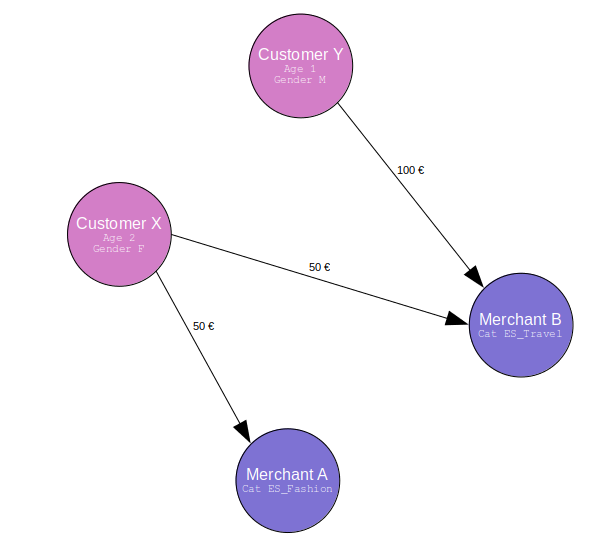

As was the previous example, this graph is heterogeneous again, we have 2 different types of nodes.

Our label (fraud vs non-fraud) is on the payment `edge`, so the objective will be to predict **which of the edges between customers and merchants are fraud.**

Much like the previous example, this would suffer from leakage issues and it still not something one would want to use for ex-ante payment or transaction evaluation. 

---
#### Note on the data set 
The data set used here (https://www.kaggle.com/datasets/ealaxi/banksim1) is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import gc

import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl
import d373c7.network as nw
import d373c7.pytorch.graph.geometric as geo

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, Linear, HeteroConv

from typing import Tuple

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

## Define some Pandas dataframes we will use as input for our network
We will create one Pandas for each node-type and one pandas for each edge-type

In [4]:
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT_32)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

payment_id = ft.FeatureSource('payment_id', ft.FEATURE_TYPE_INT_32)
customer_id = ft.FeatureSource('customer_id', ft.FEATURE_TYPE_INT_32)
merchant_id = ft.FeatureSource('merchant_id', ft.FEATURE_TYPE_INT_32)

age_oh = ft.FeatureOneHot('age_oh', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_oh', ft.FEATURE_TYPE_INT_8, gender)
category_oh = ft.FeatureOneHot('category_oh', ft.FEATURE_TYPE_INT_8, category)

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

raw_td = ft.TensorDefinition(
    'raw',
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

label_td = ft.TensorDefinition(
    'labels',
    [fraud]
)

customer_node_td = ft.TensorDefinition(
    'customer_node', 
    [
        customer_id,
        age_oh,
        gender_oh
    ])

merchant_node_td = ft.TensorDefinition(
    'merchant_node', 
    [
        merchant_id,
        category_oh
    ])

customer_to_merchant_edge_td = ft.TensorDefinition(
    'customer_to_payment_edge', 
    [
        customer_id,
        merchant_id,
        amount_scale
    ])

with en.EnginePandasNumpy(num_threads=1) as e:
    df_raw = e.from_csv(raw_td, file, inference=False)
    
# Add unique index to the payment df.
df_raw['payment_id'] = df_raw.index

# Add a unique id per each customer and merchant
df_raw['customer_id'] = pd.factorize(df_raw['customer'])[0]
df_raw['merchant_id'] = pd.factorize(df_raw['merchant'])[0]

with en.EnginePandasNumpy(num_threads=1) as e:
    df_cn = e.from_df(customer_node_td, df_raw, raw_td, inference=False)
    df_mn = e.from_df(merchant_node_td, df_raw, raw_td, inference=False)
    df_cme = e.from_df(customer_to_merchant_edge_td, df_raw, raw_td, inference=False)
    df_labels = e.from_df(label_td, df_raw, raw_td, inference=False)

# Make customer and merchant data unique
df_cn = df_cn.drop_duplicates(subset=['customer_id'])
df_mn = df_mn.drop_duplicates(subset=['merchant_id'])

# Labels to numpy
labels = df_labels.to_numpy()

2022-07-07 16:57:25.815 d373c7.engines.common          INFO     Start Engine...
2022-07-07 16:57:25.816 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-07 16:57:25.816 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-07-07 16:57:25.816 d373c7.engines.panda_numpy     INFO     Building Panda for : raw from file ../../../../data/bs140513_032310.csv
2022-07-07 16:57:26.025 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-07-07 16:57:26.026 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-07 16:57:26.032 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 8)
2022-07-07 16:57:26.032 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: raw
2022-07-07 16:57:26.071 d373c7.engines.common          INFO     Start Engine...
2022-07-07 16:57:26.071 d373c7.engines.panda_numpy     INFO     Pandas Version : 1

### Define a network structure

In [5]:
# Define Nodes
customer_node = nw.NetworkNodeDefinitionPandas('customer', customer_id, customer_node_td, df_cn)
merchant_node = nw.NetworkNodeDefinitionPandas('merchant', merchant_id, merchant_node_td, df_mn)

# Define Edges
customer_to_merchant_edge = nw.NetworkEdgeDefinitionPandas(
    name = 'customer_to_merchant',
    id_feature = payment_id,
    from_node = customer_node,
    from_node_id = customer_id,
    to_node = merchant_node,
    to_node_id = merchant_id,
    td = customer_to_merchant_edge_td,
    df = df_cme
)

# Now define the network
network = nw.NetworkDefinitionPandas(
    'network', 
    [customer_node, merchant_node], 
    [customer_to_merchant_edge]
)

### Set-up a Geometric data set.
Geometric uses a specific input data set for heterogeneous data named 'HeteroData'. Here we create a 'HeteroData', feed it the network, the labels and the split validation vs test.

In [6]:
labels = torch.as_tensor(labels, dtype=torch.float32)
g = geo.GeometricHeteroData(network, [labels], 30000, 100000)

Other than the previous graph, the egdes have attributes, i.e. the scaled amount

In [7]:
print(g.hetero_undirected)

HeteroData(
  customer={ x=[4112, 12] },
  merchant={ x=[50, 15] },
  (customer, customer_to_merchant, merchant)={
    edge_index=[2, 594643],
    edge_attr=[594643, 1]
  },
  (merchant, rev_customer_to_merchant, customer)={
    edge_index=[2, 594643],
    edge_attr=[594643, 1]
  }
)


### Define a model
This model has 2 SAGE style graph convolutional layers followed by 2 linear layers and sigmoid. The output is a score between 0 and 1 and evaluated using binary cross entropy loss. 

Note how we **only use the node features to run the convolutions**. We could have sent the payment amount around, but chose not to do that, the sheer number of edges might have drowned out the individual payment amount. Rather we chose to concatenate the amount with the 2 node embedding (the originating customer and the destination merchant) and run that concatenated tensor through 2 more linear layers.



In [8]:
class HeteroGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = HeteroConv({
            ('customer', 'customer_to_merchant', 'merchant'): SAGEConv((-1, -1), 16),
            ('merchant', 'rev_customer_to_merchant', 'customer'): SAGEConv((-1, -1), 16),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('customer', 'customer_to_merchant', 'merchant'): SAGEConv((-1, -1), 8),
            ('merchant', 'rev_customer_to_merchant', 'customer'): SAGEConv((-1, -1), 8),
        }, aggr='sum')
        self.ln1 = nn.Linear(17, 8)
        self.ln2 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Run the convolutions and activations
        x = x_dict
        x = self.conv1(x, edge_index_dict)
        x = {key: x.relu() for key, x in x.items()}
        x = self.conv2(x, edge_index_dict)
        x = {key: x.relu() for key, x in x.items()}
        # Concatenate the node embedding of the customer, of the merchant and the payment amount
        src, dst = edge_index_dict['customer', 'customer_to_merchant', 'merchant']
        edge_attr = edge_attr_dict['customer', 'customer_to_merchant', 'merchant']
        x = torch.concat((x['customer'][src], x['merchant'][dst], edge_attr), dim=1)
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.sig(x)
        return x
        
model = HeteroGNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

class WeightedBCELoss:
    def __init__(self, weights: Tuple[float, float]):
        self._weights = torch.as_tensor(weights)
        self._loss = nn.BCELoss(reduction='none')

    def __call__(self, *args, **kwargs):
        x = args[0]
        y = args[1]
        w = self._weights[y.long()]
        il = self._loss(x, y)
        return torch.mean(il * w)

loss_fn = WeightedBCELoss((1.0,2.5))

# Train

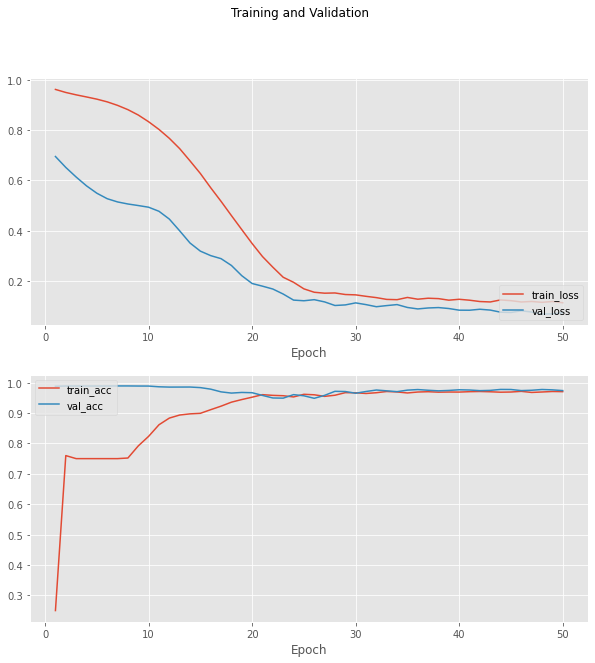

In [9]:
NUM_EPOCH = 50

def train(gmd: geo.GeometricHeteroData, model: torch.nn.Module, history: geo.GraphBinaryClassifierHistory):
    model.train()
    optimizer.zero_grad()
    mask = gmd.random_under_sampled_train_mask(3.0)
    out = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
    loss_p = loss_fn(out[mask], gmd.labels[0][mask])
    loss = loss_p
    # loss = loss_fn(out['payment'][mask], gmd.labels[0][mask])
    history.end_step(out, gmd.labels, loss, mask)
    history.end_epoch()
    loss.backward()
    optimizer.step()
    
def validate(gmd: geo.GeometricHeteroData, model: torch.nn.Module, history: geo.GraphBinaryClassifierHistory):
    with torch.no_grad():
        model.eval()
        mask = gmd.validation_mask
        out = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
        loss = loss_fn(out[mask], gmd.labels[0][mask])
        history.end_step(out, gmd.labels, loss, mask)
        history.end_epoch()

th = geo.GraphBinaryClassifierHistory()
vh = geo.GraphBinaryClassifierHistory()

for e in range(NUM_EPOCH):
    train(g, model, th)
    validate(g, model, vh)

pl.TrainPlot().plot_history((th, vh), fig_size=(10,10))

# Test 

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.32      1.00      0.48      1074

    accuracy                           0.98    100000
   macro avg       0.66      0.99      0.73    100000
weighted avg       0.99      0.98      0.98    100000


auc score : 0.9962
ap score  : 0.7004
-----------------------------------------------------


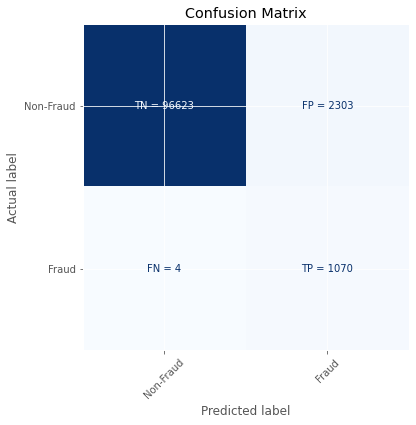

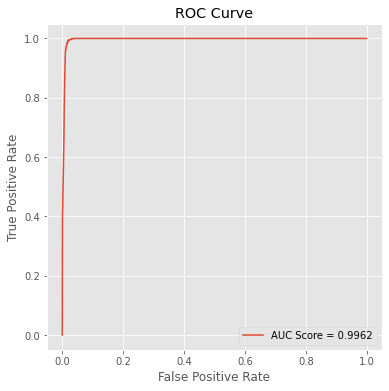

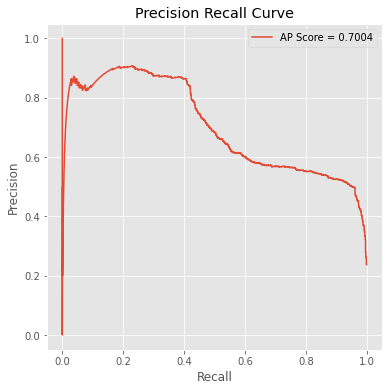

In [10]:
def test(gmd: geo.GeometricHeteroData, model: torch.nn.Module):
    with torch.no_grad():
        model.eval()
        mask = gmd.test_mask
        pr = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
        lb = torch.squeeze(gmd.labels[0][mask]).cpu().numpy()
        pr = pr[mask].cpu().numpy()
    return pr, lb

pr = test(g, model)

tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conclusion
Above showed a different approach, with a simpler network and a bit of a left-field use of the edge attributes. The performance of this model is not all that great for the effort it took, but we hope to improve it over time. We would assume the high degrees is something that could be improved. Equally tweaking the sampling balance and class weighting is likely to improve the FP ratio somewhat.